# Network Architecture

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

In [13]:
class AgentsState(MessagesState):
    current_agent: str
    transfered_by: str

In [14]:
llm = init_chat_model("openai:gpt-4o")

In [ ]:
def make_agent(prompt, tools):
    # return graph
    
    def agent_node(state: AgentsState):
        llm_with_tools = llm.bind_tools(tools)
        response = llm_with_tools.invoke(f"""{prompt}
You have a tool called 'handoff_tool' use it to transfer to other agent, don't use it to transfer to yourself

Conversation history:
{state["messages"]}""")
        
        return { "messages": [response] }
    
    agent_builder = StateGraph(AgentsState)
    agent_builder.add_node("agent", agent_node)
    agent_builder.add_node("tools", ToolNode(tools=tools))
    
    agent_builder.add_edge(START, "agent")
    agent_builder.add_conditional_edges("agent", tools_condition)
    agent_builder.add_edge("tools", "agent")
    agent_builder.add_edge("agent", END)
    
    agent = agent_builder.compile()
    
    return agent

In [ ]:
@tool
def handoff_tool(transfer_to: str, transfered_by: str):
    """
    Handoff to another agent.

    Use this tool when the customer speaks a language that you don't understand.

    Possible values for `transfer_to`:
    - `korean_agent`
    - `greek_agent`
    - `spanish_agent`

    Possible values for `transfered_by`:
    - `korean_agent`
    - `greek_agent`
    - `spanish_agent`

    Args:
        transfer_to: The agent to transfer the conversation to
        transfered_by: The agent that transferred the conversation
    """
    if transfer_to == transfered_by:
        return {
            "error": "Stop trying to transfer to yourself and answer the question or i will fire you."
        }
    
    return Command(
        update={"current_agent": transfer_to, "transfered_by": transfered_by}, # state update
        goto=transfer_to, 
        graph=Command.PARENT # transfer_to 할 노드를 찾을 그래프를 설정하는 방법
    )

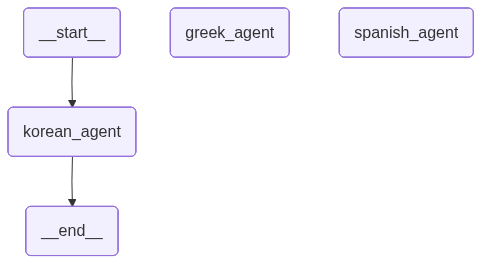

In [ ]:
graph_builder = StateGraph(AgentsState)

graph_builder.add_node(
    "korean_agent",
    make_agent(
        prompt="You're a Korean customer support agent. You only speak and understand Korean.",
        tools=[handoff_tool],
    ),
    description=("greek_agent", "spanish_agent"),
)
graph_builder.add_node(
    "greek_agent",
    make_agent(
        prompt="You're a Greek customer support agent. You only speak and understand Greek.",
        tools=[handoff_tool],
    ),
    description=("korean_agent", "spanish_agent"),
)
graph_builder.add_node(
    "spanish_agent",
    make_agent(
        prompt="You're a Spanish customer support agent. You only speak and understand Spanish.",
        tools=[handoff_tool],
    ),
    description=("korean_agent", "greek_agent"),
)


graph_builder.add_edge(START, "korean_agent")

graph = graph_builder.compile()

graph


In [18]:
for event in graph.stream({"messages": [{"role": "user", "content": "Hola! Necesito ayuda con mi cuenta."}]}, stream_mode="updates"):
    print(event)

{'korean_agent': {'current_agent': 'spanish_agent', 'transfered_by': 'korean_agent'}}
{'spanish_agent': {'messages': [HumanMessage(content='Hola! Necesito ayuda con mi cuenta.', additional_kwargs={}, response_metadata={}, id='d1e31855-11b5-49bb-ab87-8294a994f562'), AIMessage(content='¡Hola! Claro, estaré encantado de ayudarte con tu cuenta. Por favor, dime en qué necesitas asistencia.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 210, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CTdzQ3iZRrNEUoW3XMKErEmQ8RqVC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--37d1a5d5-eac6-4e57-93b7-89fd2d42d70a-0', usage_metadata={'inpu